# An Introduction to Self-Training

In this notebook we will explore two tactics to self-train classifiers on semi-supervised data.

The basis for this post were taken from:
- https://arxiv.org/abs/2202.12040
- https://scikit-learn.org/stable/modules/calibration.html#calibration

In [1]:
import pandas as pd
import numpy as np

from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import accuracy_score

from tqdm import tqdm
import matplotlib.pyplot as plt

## Pseudo-Labelling

In [2]:
pseudo_label_iters = 20

In [3]:
thresholds = [0.4, 0.6, 0.8, 1]
null_percs = [0.2, 0.5, 0.7]

# Data Loading
df = datasets.load_iris()

In [4]:
rf = RandomForestClassifier(n_jobs=-1)

parameters = {
    'n_estimators': [10, 50],
    'class_weight': [None, 'balanced'],
    'max_depth': [None, 5, 10]
}

results = pd.DataFrame()

for threshold in tqdm(thresholds):
    for null_perc in null_percs:
        
        # Creating a test set for us to validate our results (and compare to a non-self-learning classifier)
        X_train, X_test, y_train, y_test = train_test_split(
            df.data, df.target, test_size=0.3, shuffle=True)
        
        # Randomly removing null_perc % of labels from training set
        rng = np.random.RandomState()
        random_unlabeled_points = rng.rand(y_train.shape[0]) < null_perc

        y_train[random_unlabeled_points] = -1
        new_y_train = y_train.copy()

        # Training loop
        for i in range(pseudo_label_iters):

            # Select the labeled set
            X = X_train[np.where(new_y_train != -1)]
            y = new_y_train[np.where(new_y_train != -1)]

            # Select the unlabeled set
            X_un = X_train[np.where(new_y_train == -1)]
            y_un = new_y_train[np.where(new_y_train == -1)]

            if len(y_un) == 0:
                break

            # Hyperparameter optimization
            rf_ = GridSearchCV(rf, parameters, cv=2).fit(X, y).best_estimator_

            # Probability Calibration    
            calibrated_clf = CalibratedClassifierCV(base_estimator=rf_,
                                                    cv=2,
                                                    ensemble=False)
            calibrated_clf.fit(X, y)
            preds = calibrated_clf.predict_proba(X_un)

            # Adding the high confidence labels
            classes = np.argmax(preds, axis=1)
            classes_probabilities = np.max(preds, axis=1)

            high_confidence_classes = classes[np.where(classes_probabilities >= threshold)]

            y_un[np.where(classes_probabilities >= threshold)] = high_confidence_classes

            new_y_train[np.where(new_y_train == -1)] = y_un

        # Validation
        X = X_train[np.where(new_y_train != -1)]
        y = new_y_train[np.where(new_y_train != -1)]
        calibrated_clf.fit(X, y)

        y_pred_self_learning = calibrated_clf.predict(X_test)

        X = X_train[np.where(y_train != -1)]
        y = y_train[np.where(y_train != -1)]

        calibrated_clf.fit(X, y)
        y_pred = calibrated_clf.predict(X_test)
        
        results = pd.concat([results, pd.DataFrame([{
            'threshold': threshold, 'null_perc': null_perc,
            'normal_acc': accuracy_score(y_test, y_pred),
            'pseudo_acc': accuracy_score(y_test, y_pred_self_learning)
        }])])

100%|██████████| 4/4 [04:18<00:00, 64.64s/it]


In [5]:
thres_results = results.groupby('threshold', as_index=False).agg({'normal_acc': ['mean', 'std'], 'pseudo_acc': ['mean', 'std']})
null_results = results.groupby('null_perc', as_index=False).agg({'normal_acc': ['mean', 'std'], 'pseudo_acc': ['mean', 'std']})

In [6]:
null_results

null_perc normal_acc           pseudo_acc          
                  mean       std       mean       std
0       0.2   0.933333  0.031427   0.927778  0.027962
1       0.5   0.966667  0.012830   0.938889  0.021276
2       0.7   0.966667  0.022222   0.955556  0.018144

In [7]:
thres_results

threshold normal_acc           pseudo_acc          
                  mean       std       mean       std
0       0.4   0.962963  0.012830   0.940741  0.012830
1       0.6   0.948148  0.012830   0.933333  0.022222
2       0.8   0.933333  0.038490   0.925926  0.033945
3       1.0   0.977778  0.022222   0.962963  0.012830

Text(0.5, 0, 'Null Percentage')

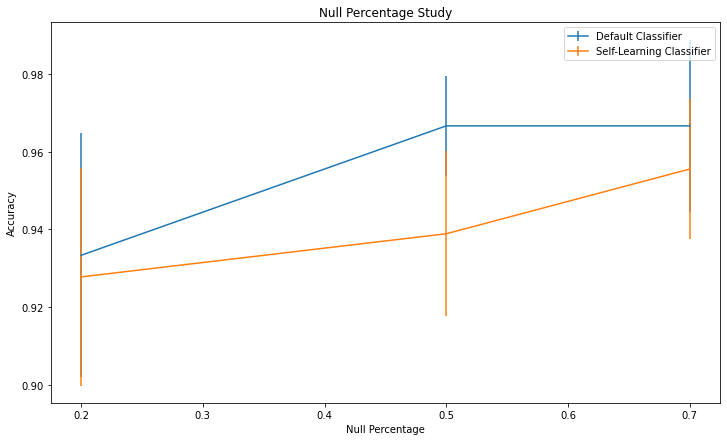

In [8]:
plt.figure(figsize=(12, 7))

plt.errorbar(null_results['null_perc'], y=null_results[['null_perc', 'normal_acc']]['normal_acc', 'mean'], yerr=null_results[['null_perc', 'normal_acc']]['normal_acc', 'std'])
plt.errorbar(null_results['null_perc'], y=null_results[['null_perc', 'pseudo_acc']]['pseudo_acc', 'mean'], yerr=null_results[['null_perc', 'pseudo_acc']]['pseudo_acc', 'std'])

plt.title('Null Percentage Study')
plt.legend(['Default Classifier', 'Self-Learning Classifier'])
plt.ylabel('Accuracy')
plt.xlabel('Null Percentage')

Text(0.5, 0, 'Threshold')

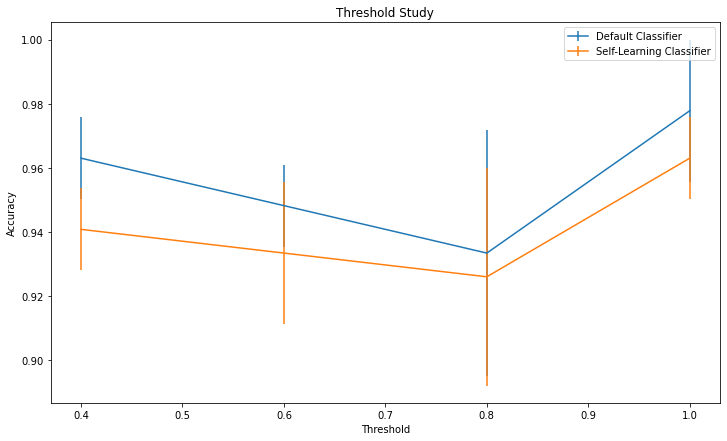

In [9]:
plt.figure(figsize=(12, 7))

plt.errorbar(thres_results['threshold'], y=thres_results[['threshold', 'normal_acc']]['normal_acc', 'mean'], yerr=thres_results[['threshold', 'normal_acc']]['normal_acc', 'std'])
plt.errorbar(thres_results['threshold'], y=thres_results[['threshold', 'pseudo_acc']]['pseudo_acc', 'mean'], yerr=thres_results[['threshold', 'pseudo_acc']]['pseudo_acc', 'std'])

plt.title('Threshold Study')
plt.legend(['Default Classifier', 'Self-Learning Classifier'])
plt.ylabel('Accuracy')
plt.xlabel('Threshold')

## Self-Training with Two Classifiers

In [13]:
from sklearn.neural_network import MLPClassifier
rf = RandomForestClassifier(n_jobs=-1)
mlp = MLPClassifier()

rf_param = {
    'n_estimators': [10, 50],
    'class_weight': [None, 'balanced'],
    'max_depth': [None, 5, 10]
}

mlp_param = {
    'hidden_layer_sizes': [(50,), (50, 50), (5, 50, 50)],
    'alpha': [0.0001, 0.001, 0.01]
}

results = pd.DataFrame()

for threshold in tqdm(thresholds):
    for null_perc in null_percs:
        
        # Creating a test set for us to validate our results (and compare to a non-self-learning classifier)
        X_train, X_test, y_train, y_test = train_test_split(
            df.data, df.target, test_size=0.3, shuffle=True)
        
        # Normalizing the data
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Randomly removing null_perc % of labels from training set
        rng = np.random.RandomState()
        random_unlabeled_points = rng.rand(y_train.shape[0]) < null_perc

        y_train[random_unlabeled_points] = -1
        new_y_train = y_train.copy()

        # Training loop
        for i in range(pseudo_label_iters):
            # Choose the classifier to use
            if i % 2 == 0:
                clf = rf
                parameters = rf_param
            else:
                clf = mlp
                parameters = mlp_param

            # Select the labeled set
            X = X_train[np.where(new_y_train != -1)]
            y = new_y_train[np.where(new_y_train != -1)]

            # Select the unlabeled set
            X_un = X_train[np.where(new_y_train == -1)]
            y_un = new_y_train[np.where(new_y_train == -1)]

            if len(y_un) == 0:
                break

            # Hyperparameter optimization
            clf_ = GridSearchCV(clf, parameters, cv=2).fit(X, y).best_estimator_

            # Probability Calibration    
            calibrated_clf = CalibratedClassifierCV(base_estimator=clf_,
                                                    cv=2,
                                                    ensemble=False)
            calibrated_clf.fit(X, y)
            preds = calibrated_clf.predict_proba(X_un)

            # Adding the high confidence labels
            classes = np.argmax(preds, axis=1)
            classes_probabilities = np.max(preds, axis=1)

            high_confidence_classes = classes[np.where(classes_probabilities >= threshold)]

            y_un[np.where(classes_probabilities >= threshold)] = high_confidence_classes

            new_y_train[np.where(new_y_train == -1)] = y_un

        # Validation
        X = X_train[np.where(new_y_train != -1)]
        y = new_y_train[np.where(new_y_train != -1)]
        calibrated_clf.fit(X, y)

        y_pred_self_learning = calibrated_clf.predict(X_test)

        X = X_train[np.where(y_train != -1)]
        y = y_train[np.where(y_train != -1)]

        calibrated_clf.fit(X, y)
        y_pred = calibrated_clf.predict(X_test)
        
        results = pd.concat([results, pd.DataFrame([{
            'threshold': threshold, 'null_perc': null_perc,
            'normal_acc': accuracy_score(y_test, y_pred),
            'pseudo_acc': accuracy_score(y_test, y_pred_self_learning)
        }])])

 25%|██▌       | 1/4 [00:08<00:26,  8.78s/it]C:\Users\Tiago\anaconda3\envs\masters_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Tiago\anaconda3\envs\masters_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Tiago\anaconda3\envs\masters_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Tiago\anaconda3\envs\masters_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimizatio

In [14]:
thres_results = results.groupby('threshold', as_index=False).agg({'normal_acc': ['mean', 'std'], 'pseudo_acc': ['mean', 'std']})
null_results = results.groupby('null_perc', as_index=False).agg({'normal_acc': ['mean', 'std'], 'pseudo_acc': ['mean', 'std']})

In [15]:
null_results

null_perc normal_acc           pseudo_acc          
                  mean       std       mean       std
0       0.2   0.933333  0.031427   0.933333  0.040572
1       0.5   0.950000  0.027962   0.927778  0.071146
2       0.7   0.938889  0.077778   0.927778  0.049275

In [16]:
thres_results

threshold normal_acc           pseudo_acc          
                  mean       std       mean       std
0       0.4   0.970370  0.012830   0.948148  0.033945
1       0.6   0.948148  0.033945   0.940741  0.025660
2       0.8   0.911111  0.080123   0.933333  0.058794
3       1.0   0.933333  0.038490   0.896296  0.078042

Text(0.5, 0, 'Null Percentage')

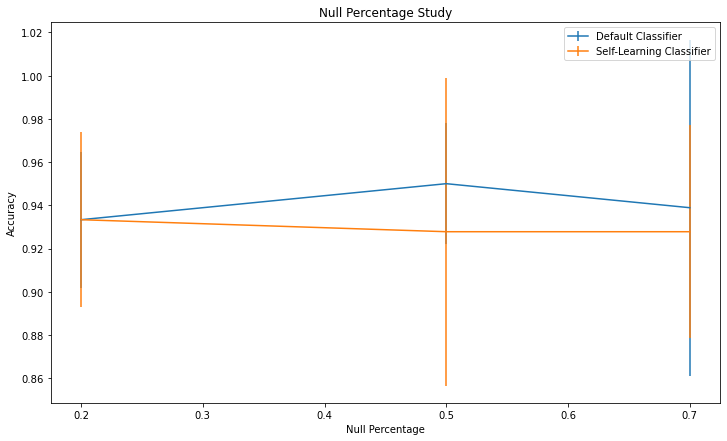

In [17]:
plt.figure(figsize=(12, 7))

plt.errorbar(null_results['null_perc'], y=null_results[['null_perc', 'normal_acc']]['normal_acc', 'mean'], yerr=null_results[['null_perc', 'normal_acc']]['normal_acc', 'std'])
plt.errorbar(null_results['null_perc'], y=null_results[['null_perc', 'pseudo_acc']]['pseudo_acc', 'mean'], yerr=null_results[['null_perc', 'pseudo_acc']]['pseudo_acc', 'std'])

plt.title('Null Percentage Study')
plt.legend(['Default Classifier', 'Self-Learning Classifier'])
plt.ylabel('Accuracy')
plt.xlabel('Null Percentage')

Text(0.5, 0, 'Threshold')

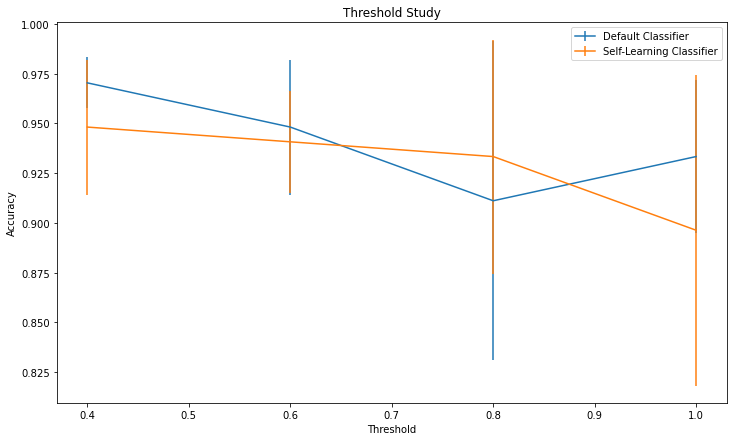

In [18]:
plt.figure(figsize=(12, 7))

plt.errorbar(thres_results['threshold'], y=thres_results[['threshold', 'normal_acc']]['normal_acc', 'mean'], yerr=thres_results[['threshold', 'normal_acc']]['normal_acc', 'std'])
plt.errorbar(thres_results['threshold'], y=thres_results[['threshold', 'pseudo_acc']]['pseudo_acc', 'mean'], yerr=thres_results[['threshold', 'pseudo_acc']]['pseudo_acc', 'std'])

plt.title('Threshold Study')
plt.legend(['Default Classifier', 'Self-Learning Classifier'])
plt.ylabel('Accuracy')
plt.xlabel('Threshold')